In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import os
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import plotly.graph_objects as go
import plotly.offline as pyo
import datetime
import matplotlib.dates as mdates
import sys
sys.path.insert(1, '../../auxiliary_scripts')
from output_postprocessing import parse_methane_series, parse_layer_file, parse_univariate_file

In [3]:
layer_datafile_names={'layers': 'layers  1  1.dat'}

methane_datafile_names={'methane': 'methane_series  1  1.dat'}

univariate_datafile_names = {
                  'water_temp': 'water_temp  1  1f2.dat',
                  'soil_temp': 'soil_temp  1  1f2.dat',
                  'co2_water': 'co2_water  1  1f2.dat',
                  'ch4_water': 'methane_water  1  1f2.dat',
                  'o2_water': 'oxygen_water  1  1f2.dat',
                  'doc_water': 'DOC  1  1f2.dat',
                  'pocl_water': 'POCL  1  1f2.dat', #live POC
                  'pocd_water': 'POCD  1  1f2.dat',
                  'phosph_water': 'phosph_water  1  1f2.dat',
                  'prodox': 'prodox  1  1f2.dat',
                  'sod': 'sod  1  1f2.dat'} #dead POC

In [4]:
df_results = []
df_layers = []
df_methanes=[]
out_path = os

for dir in os.listdir():
    
    df_result = pd.DataFrame()
    
    if os.path.isdir(dir) and '.' not in dir:

        run_path = os.path.join(os.getcwd(), dir)
        
        run_path=os.path.join(run_path, 'time_series')
        df_layer = parse_layer_file(os.path.join(run_path, layer_datafile_names['layers']))
        df_methane = parse_methane_series(os.path.join(run_path, methane_datafile_names['methane']))
        
        for var_key in univariate_datafile_names:
            
            if(len(df_result)==0):
                df_result = parse_univariate_file(os.path.join(run_path, univariate_datafile_names[var_key]), var_key)
                

            else: 
                df_result = pd.merge(df_result, parse_univariate_file(os.path.join(run_path, univariate_datafile_names[var_key]), var_key))
                
        if 'unburned' in dir:
            df_result['pond'] = 'unburned'
            df_layer['pond'] = 'unburned'
            df_methane['pond'] = 'unburned'
        else:
            df_result['pond'] = 'burned'
            df_layer['pond'] = 'burned'
            df_methane['pond'] = 'burned'

        run = ''.join(dir.split('-')[2:])
        
        if run == '':
            df_result['run'] = 'control'
            df_layer['run'] = 'control'
            df_methane['run'] = 'control'
        else:
            df_result['run'] = run
            df_layer['run'] = run
            df_methane['run'] = run
        
        df_results.append(df_result)
        df_layers.append(df_layer)
        df_methanes.append(df_methane)

df_results = pd.concat(df_results)
df_results = df_results.replace(-999, np.nan)

df_layers = pd.concat(df_layers)
df_layers = df_layers.replace(-999, np.nan)

df_methanes = pd.concat(df_methanes)
df_methanes = df_methanes.replace(-999, np.nan)
df_results['run'].unique()

array(['nosnow5yr', 'tplus1pct5yr', '5yr', 'swin20pct5yr'], dtype=object)

In [6]:
df_results_depth_avg = df_results.groupby(by=['pond', 'run', 'Date']).mean().reset_index()

In [7]:
runs_names=df_results['run'].unique()

In [8]:
runs_names

array(['nosnow5yr', 'tplus1pct5yr', '5yr', 'swin20pct5yr'], dtype=object)

In [9]:
time_min=pd.to_datetime('2022-07-01')
time_max=pd.to_datetime('2023-07-01')

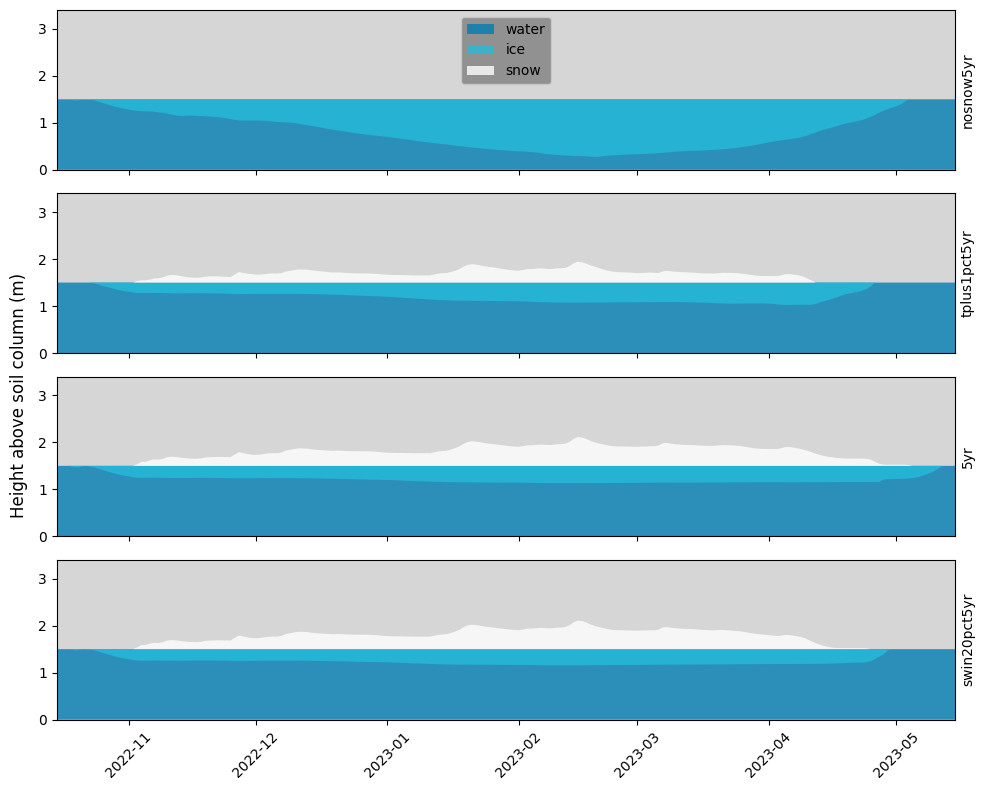

In [31]:
fig, axes = plt.subplots(len(runs_names),1, figsize=(10,2*len(runs_names)), sharex=True, sharey=True)


for i, run in enumerate(runs_names):
    
    run_data = df_layers.loc[(df_layers['run']==runs_names[i]) & (df_layers['pond']=='burned')]
    
    axes[i].fill_between(run_data['Date'], 0, run_data['water layer thickness, m'],  
                    facecolor ='#027eb3', alpha = 0.8, label='water')
    axes[i].fill_between(run_data['Date'], run_data['water layer thickness, m']-run_data['ice layer thickness,   m'], run_data['water layer thickness, m'],  
                    facecolor ='#25bbd9', alpha = 0.8, label='ice')
    axes[i].fill_between(run_data['Date'], run_data['water layer thickness, m'], run_data['snow layer thickness,  m'] + run_data['water layer thickness, m'],  
                    facecolor ='white', alpha = 0.8, label='snow')

    axes[i].set_facecolor('#d6d6d6')

    axes[i].set_ylabel(runs_names[i])
    axes[i].yaxis.set_label_position("right")
    axes[i].set_facecolor('#d6d6d6')

axes[0].legend(loc='upper center', facecolor = 'grey')
    

plt.ylim(0, 3.4)
plt.xticks(rotation=45)
plt.xlim(pd.to_datetime('2022-10-15'),pd.to_datetime('2023-05-15'))
fig.supylabel('Height above soil column (m)')
fig.tight_layout()

#plt.savefig('YKD-SA/figures/SA_layers.jpg', dpi=300)

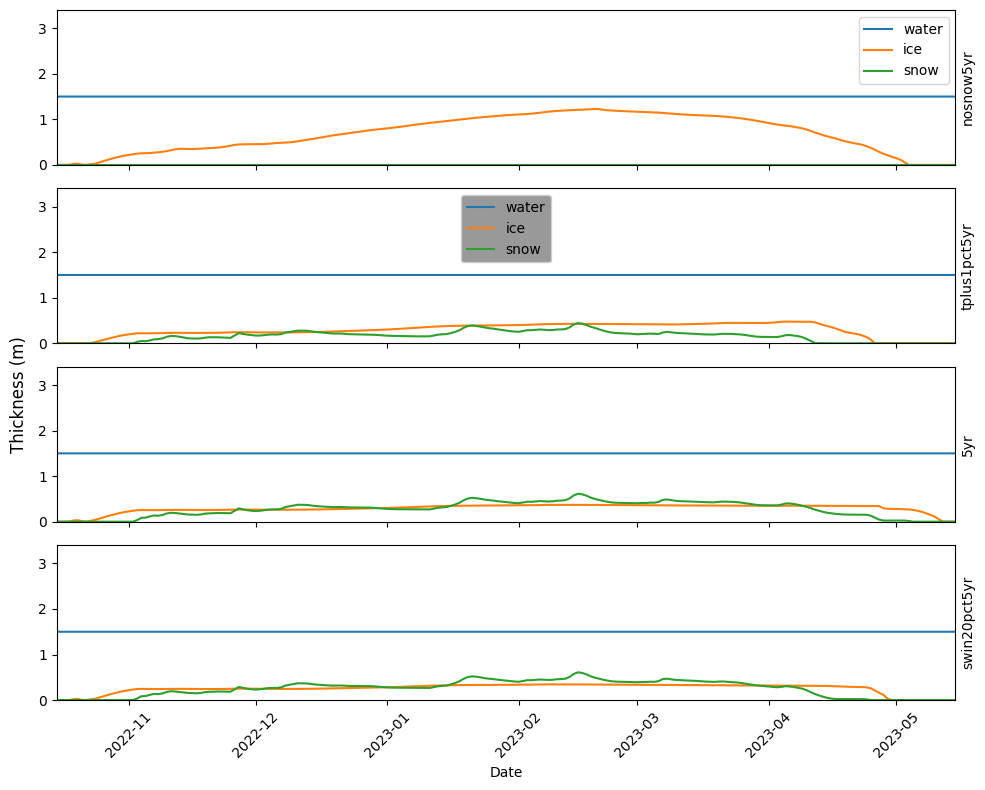

In [39]:
fig, axes = plt.subplots(len(runs_names),1, figsize=(10,2*len(runs_names)), sharex=True, sharey=True)


for i, run in enumerate(runs_names):
    
    run_data = df_layers.loc[(df_layers['run']==runs_names[i]) & (df_layers['pond']=='burned')]

    sns.lineplot(x=run_data['Date'], y=run_data['water layer thickness, m'], ax=axes[i], label='water')
    sns.lineplot(x=run_data['Date'], y=run_data['ice layer thickness,   m'], ax=axes[i], label='ice')
    sns.lineplot(x=run_data['Date'], y=run_data['snow layer thickness,  m'], ax=axes[i], label='snow')

    if i!=0:
        axes[i].get_legend().remove()
        

    axes[i].set_ylabel(runs_names[i])
    axes[i].yaxis.set_label_position("right")

axes[1].legend(loc='upper center', facecolor = 'grey')
    
plt.ylim(0, 3.4)
plt.xticks(rotation=45)
plt.xlim(pd.to_datetime('2022-10-15'),pd.to_datetime('2023-05-15'))
fig.supylabel('Thickness (m)')
fig.tight_layout()

(19174.0, 19539.0)

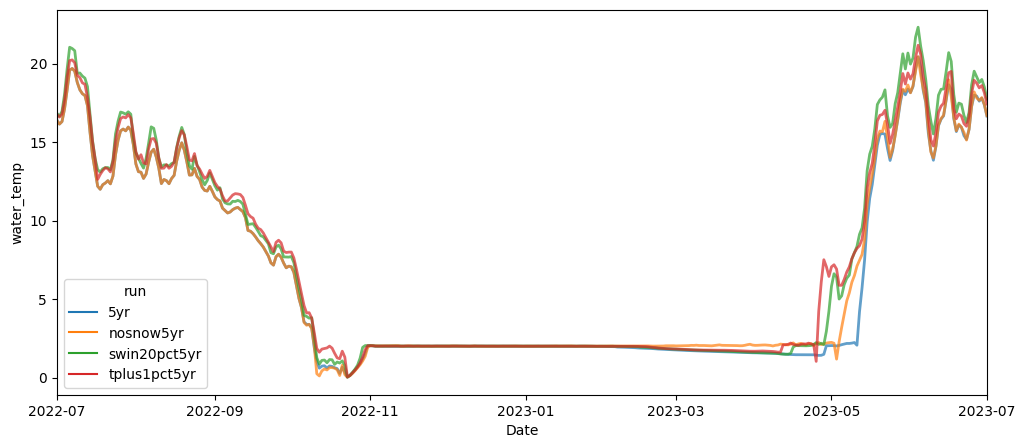

In [11]:
fig, axes = plt.subplots(figsize=(12,5), sharex=True)

sns.lineplot(data= df_results_depth_avg.loc[df_results_depth_avg['pond']=='burned'], 
                 x='Date', y='water_temp', hue='run', alpha=0.7, linewidth=2)
plt.xlim(pd.to_datetime('2022-07-01'),pd.to_datetime('2023-07-01'))

(19174.0, 19539.0)

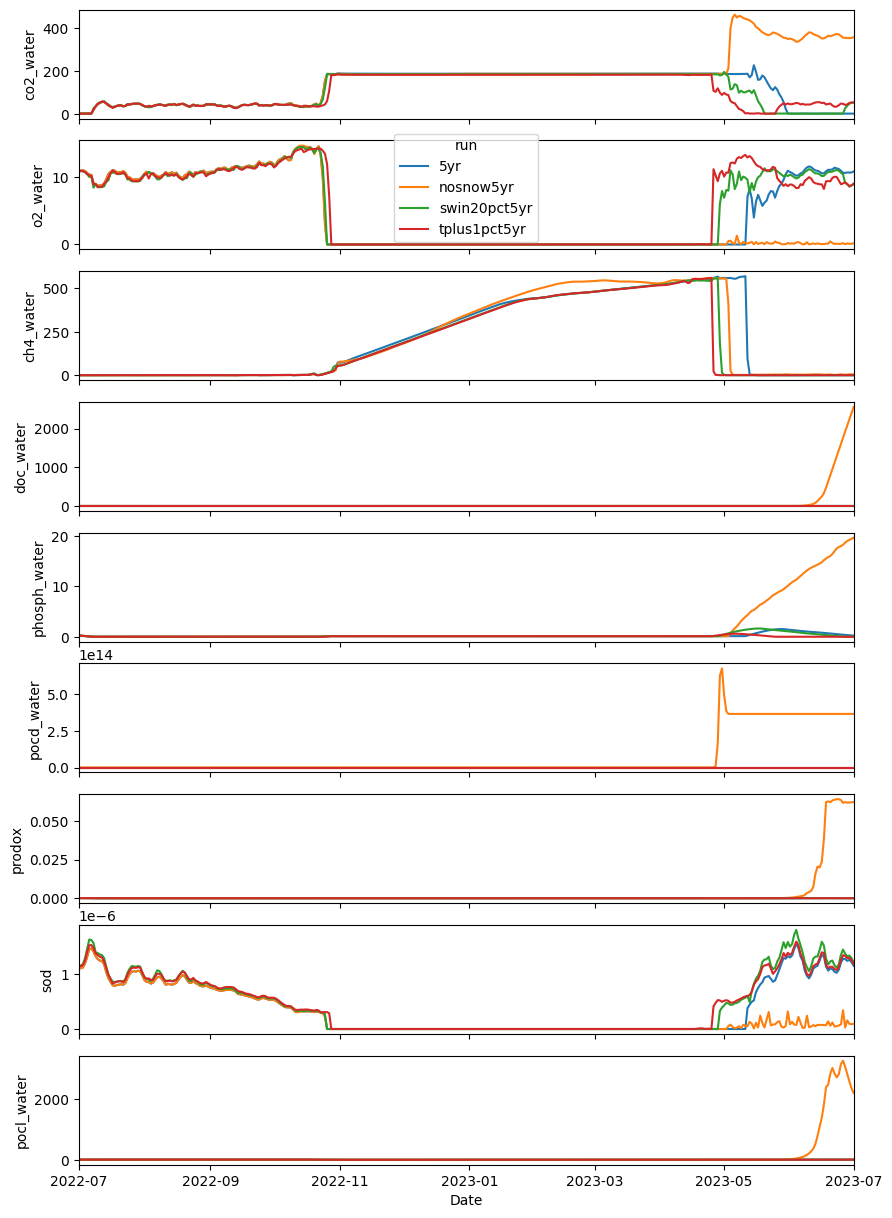

In [12]:
fig, axes = plt.subplots(9, 1,figsize=(10,15), sharex=True)

sns.lineplot(data= df_results_depth_avg.loc[df_results_depth_avg['pond']=='burned'], 
                 x='Date', y='co2_water', hue='run', ax = axes[0], legend=False)
sns.lineplot(data= df_results_depth_avg.loc[df_results_depth_avg['pond']=='burned'], 
                 x='Date', y='o2_water', hue='run', ax = axes[1])
sns.lineplot(data= df_results_depth_avg.loc[df_results_depth_avg['pond']=='burned'], 
                 x='Date', y='ch4_water', hue='run', ax = axes[2], legend=False)
#axes[2].set_ylim(0,2)
sns.lineplot(data= df_results_depth_avg.loc[df_results_depth_avg['pond']=='burned'], 
                 x='Date', y='doc_water', hue='run', ax = axes[3], legend=False)

#axes[4].set_ylim(0,10)
sns.lineplot(data= df_results_depth_avg.loc[df_results_depth_avg['pond']=='burned'], 
                 x='Date', y='phosph_water', hue='run', ax = axes[4], legend=False)

sns.lineplot(data= df_results_depth_avg.loc[df_results_depth_avg['pond']=='burned'], 
                 x='Date', y='pocd_water', hue='run', ax = axes[5], legend=False)


sns.lineplot(data= df_results_depth_avg.loc[df_results_depth_avg['pond']=='burned'], 
                 x='Date', y='prodox', hue='run', ax = axes[6], legend=False)

sns.lineplot(data= df_results_depth_avg.loc[df_results_depth_avg['pond']=='burned'], 
                 x='Date', y='sod', hue='run', ax = axes[7], legend=False)

sns.lineplot(data= df_results_depth_avg.loc[df_results_depth_avg['pond']=='burned'], 
                 x='Date', y='pocl_water', hue='run', ax = axes[8], legend=False)
plt.xlim(pd.to_datetime('2022-07-01'),pd.to_datetime('2023-07-01'))

(18809.0, 19539.0)

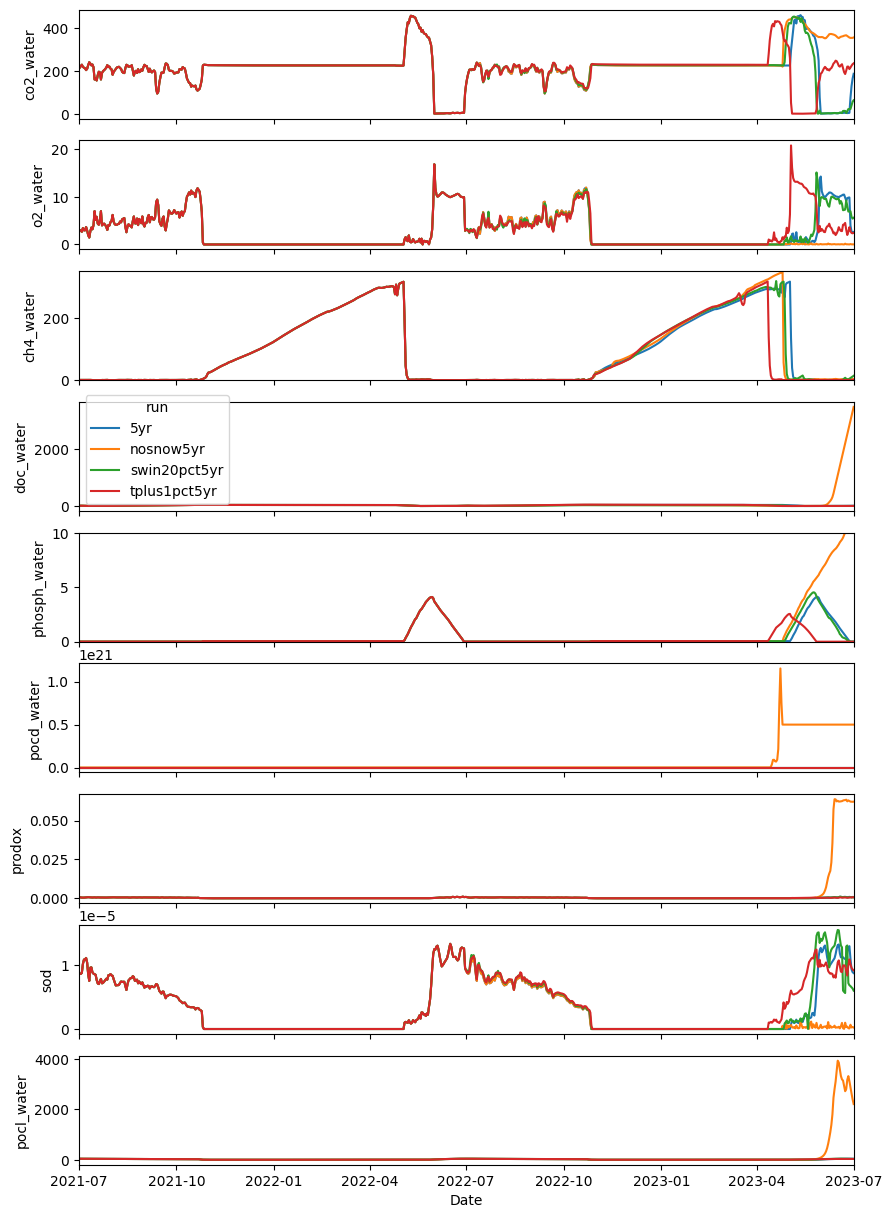

In [13]:
fig, axes = plt.subplots(9, 1,figsize=(10,15), sharex=True)

sns.lineplot(data= df_results_depth_avg.loc[df_results_depth_avg['pond']=='unburned'], 
                 x='Date', y='co2_water', hue='run', ax = axes[0], legend=False)
sns.lineplot(data= df_results_depth_avg.loc[df_results_depth_avg['pond']=='unburned'], 
                 x='Date', y='o2_water', hue='run', ax = axes[1], legend=False)
sns.lineplot(data= df_results_depth_avg.loc[df_results_depth_avg['pond']=='unburned'], 
                 x='Date', y='ch4_water', hue='run', ax = axes[2], legend=False)
axes[2].set_ylim(0,350)
sns.lineplot(data= df_results_depth_avg.loc[df_results_depth_avg['pond']=='unburned'], 
                 x='Date', y='doc_water', hue='run', ax = axes[3])

axes[4].set_ylim(0,10)
sns.lineplot(data= df_results_depth_avg.loc[df_results_depth_avg['pond']=='unburned'], 
                 x='Date', y='phosph_water', hue='run', ax = axes[4], legend=False)

sns.lineplot(data= df_results_depth_avg.loc[df_results_depth_avg['pond']=='unburned'], 
                 x='Date', y='pocd_water', hue='run', ax = axes[5], legend=False)


sns.lineplot(data= df_results_depth_avg.loc[df_results_depth_avg['pond']=='unburned'], 
                 x='Date', y='prodox', hue='run', ax = axes[6], legend=False)

sns.lineplot(data= df_results_depth_avg.loc[df_results_depth_avg['pond']=='unburned'], 
                 x='Date', y='sod', hue='run', ax = axes[7], legend=False)

sns.lineplot(data= df_results_depth_avg.loc[df_results_depth_avg['pond']=='unburned'], 
                 x='Date', y='pocl_water', hue='run', ax = axes[8], legend=False)
plt.xlim(pd.to_datetime('2021-07-01'),pd.to_datetime('2023-07-01'))

In [14]:
sample_comp_melt = pd.melt(df_results.loc[(df_results_depth_avg['Date']>'2022-07-01') 
                           & (df_results_depth_avg['Date']<='2023-07-01')], 
                           id_vars=['Date', 'pond', 'run'])

sample_comp_melt_depth_avg = pd.melt(df_results_depth_avg.loc[(df_results_depth_avg['Date']>'2022-07-01') 
                                    & (df_results_depth_avg['Date']<='2023-07-01')], 
                                    id_vars=['Date', 'pond', 'run'])

In [41]:
methane_comp_melt=pd.melt(df_methanes.loc[(df_results_depth_avg['Date']>'2022-07-01') 
    & (df_results_depth_avg['Date']<='2023-07-01')], 
    id_vars=['Date', 'pond', 'run'])

# Summer box plots

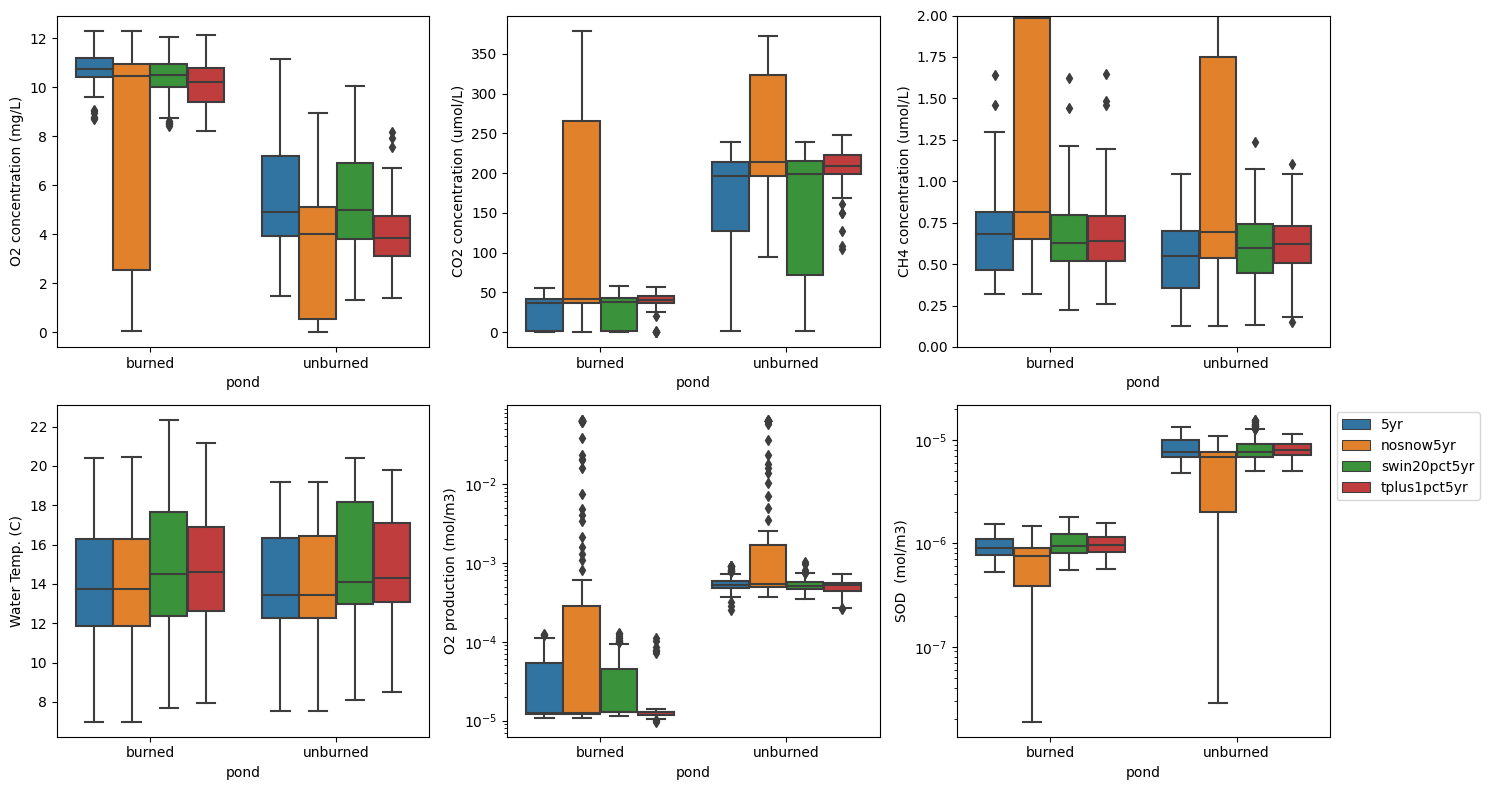

In [68]:
summer_box_data = sample_comp_melt_depth_avg.loc[(sample_comp_melt_depth_avg['Date'].dt.month<=9) & (sample_comp_melt_depth_avg['Date'].dt.month>=6)]

fig, axes=plt.subplots(2,3, figsize=(15,8))
sns.boxplot(data=summer_box_data.loc[summer_box_data['variable'] == 'o2_water'], 
            x='pond', y='value', hue='run', ax=axes[0,0])
#axes[0,0].legend(title='', loc='lower left')
axes[0,0].legend().remove()
axes[0,0].set_ylabel('O2 concentration (mg/L)')

sns.boxplot(data=summer_box_data.loc[summer_box_data['variable'] == 'co2_water'], 
            x='pond', y='value', hue='run', ax=axes[0,1])
axes[0,1].legend().remove()
axes[0,1].set_ylabel('CO2 concentration (umol/L)')

sns.boxplot(data=summer_box_data.loc[summer_box_data['variable'] == 'ch4_water'], 
            x='pond', y='value', hue='run', ax=axes[0,2])
axes[0,2].legend().remove()
axes[0,2].set_ylabel('CH4 concentration (umol/L)')
axes[0,2].set_ylim(0,2)

sns.boxplot(data=summer_box_data.loc[summer_box_data['variable'] == 'water_temp'], 
            x='pond', y='value', hue='run', ax=axes[1,0])
axes[1,0].legend().remove()
axes[1,0].set_ylabel('Water Temp. (C)')

sns.boxplot(data=summer_box_data.loc[summer_box_data['variable'] == 'prodox'], 
            x='pond', y='value', hue='run', ax=axes[1,1])
axes[1,1].legend().remove()
axes[1,1].set_ylabel('O2 production (mol/m3)')
axes[1,1].set_yscale('log')

sns.boxplot(data=summer_box_data.loc[summer_box_data['variable'] == 'sod'], 
            x='pond', y='value', hue='run', ax=axes[1,2])

axes[1, 2].legend(title='', loc='upper left', bbox_to_anchor=(1, 1))
axes[1,2].set_ylabel('SOD  (mol/m3)')
axes[1,2].set_yscale('log')
#axes[1,2].set_ylim(0,1e-6)

fig.tight_layout()
plt.savefig('met_exp_results_summer.jpg', dpi=300)

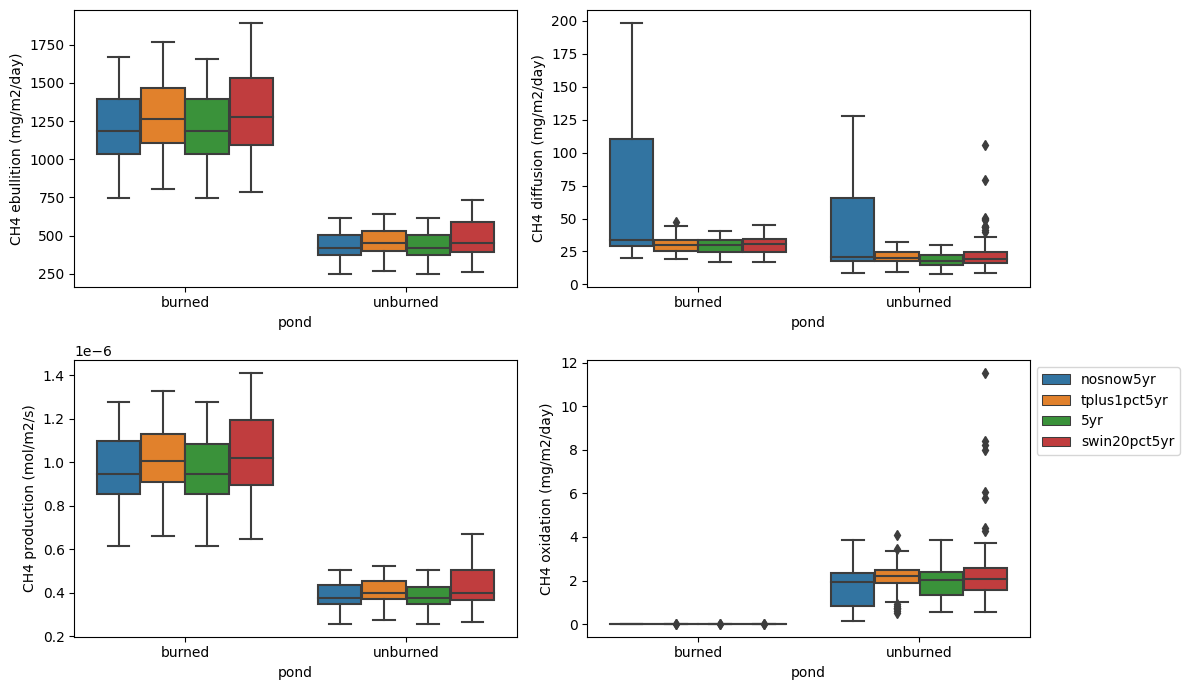

In [67]:
summer_box_data_ch4 = methane_comp_melt.loc[(methane_comp_melt['Date'].dt.month<=9) & (methane_comp_melt['Date'].dt.month>=6)]

fig, axes=plt.subplots(2,2, figsize=(12,7))
sns.boxplot(data=summer_box_data_ch4.loc[summer_box_data_ch4['variable'] == 'methane_ebul_mg/(m**2*day)'], 
            x='pond', y='value', hue='run', ax=axes[0,0])
axes[0,0].legend().remove()
#axes[0,0].legend(title='', loc='lower left')
axes[0,0].set_ylabel('CH4 ebullition (mg/m2/day)')

sns.boxplot(data=summer_box_data_ch4.loc[summer_box_data_ch4['variable'] == 'methane_turb_flux_mg/(m**2*day)'], 
            x='pond', y='value', hue='run', ax=axes[0,1])
axes[0,1].legend().remove()
axes[0,1].set_ylabel('CH4 diffusion (mg/m2/day)')
#axes[0,1].set_ylim(0,100)

sns.boxplot(data=summer_box_data_ch4.loc[summer_box_data_ch4['variable'] == 'methane_prod_young_mol/(m**2*s)'], 
            x='pond', y='value', hue='run', ax=axes[1,0])
axes[1,0].legend().remove()
axes[1,0].set_ylabel('CH4 production (mol/m2/s)')
#axes[0,2].set_ylim(0,2)

sns.boxplot(data=summer_box_data_ch4.loc[summer_box_data_ch4['variable'] == 'methane_oxid_mg/(m**2*day)'], 
            x='pond', y=summer_box_data_ch4.loc[summer_box_data_ch4['variable'] == 'methane_oxid_mg/(m**2*day)']['value']*-1, hue='run', ax=axes[1,1])
#axes[1,1].legend().remove()
axes[1,1].legend(title='', loc='upper left', bbox_to_anchor=(1, 1))
axes[1,1].set_ylabel('CH4 oxidation (mg/m2/day)')
#axes[1,1].set_ylim(0,1e-2)
#axes[1,1].set_yscale('log')

fig.tight_layout()
plt.savefig('met_exp_ch4_results_summer.jpg', dpi=300)

# Winter box plots

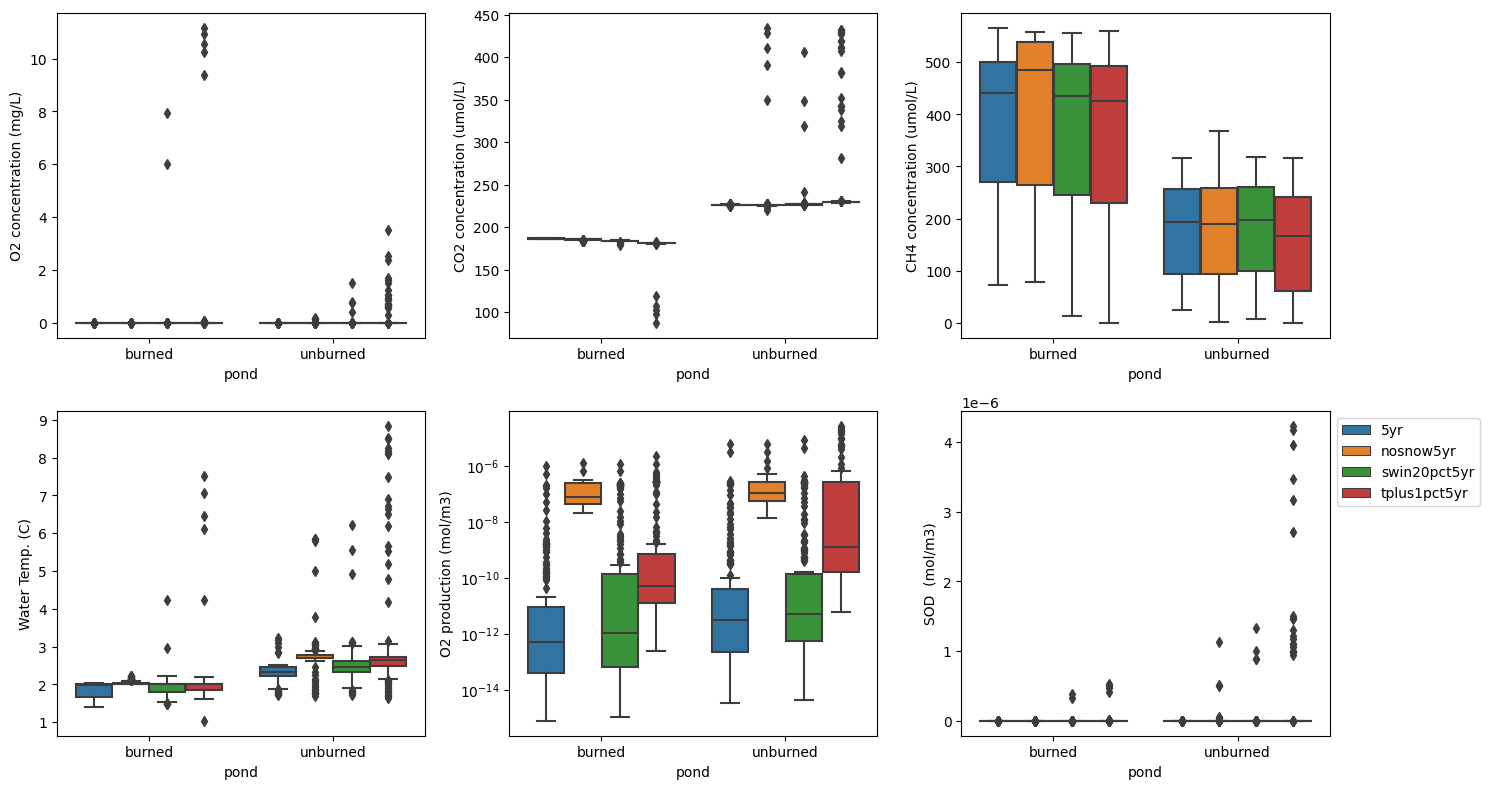

In [66]:
winter_box_data = sample_comp_melt_depth_avg.loc[(sample_comp_melt_depth_avg['Date'].dt.month<=4) | (sample_comp_melt_depth_avg['Date'].dt.month>=11)]

fig, axes=plt.subplots(2,3, figsize=(15,8))
sns.boxplot(data=winter_box_data.loc[winter_box_data['variable'] == 'o2_water'], 
            x='pond', y='value', hue='run', ax=axes[0,0])
#axes[0,0].legend(title='', loc='lower left')
axes[0,0].legend().remove()
axes[0,0].set_ylabel('O2 concentration (mg/L)')

sns.boxplot(data=winter_box_data.loc[winter_box_data['variable'] == 'co2_water'], 
            x='pond', y='value', hue='run', ax=axes[0,1])
axes[0,1].legend().remove()
axes[0,1].set_ylabel('CO2 concentration (umol/L)')

sns.boxplot(data=winter_box_data.loc[winter_box_data['variable'] == 'ch4_water'], 
            x='pond', y='value', hue='run', ax=axes[0,2])
axes[0,2].legend().remove()
axes[0,2].set_ylabel('CH4 concentration (umol/L)')
#axes[0,2].set_ylim(0,2)

sns.boxplot(data=winter_box_data.loc[winter_box_data['variable'] == 'water_temp'], 
            x='pond', y='value', hue='run', ax=axes[1,0])
axes[1,0].legend().remove()
axes[1,0].set_ylabel('Water Temp. (C)')

sns.boxplot(data=winter_box_data.loc[winter_box_data['variable'] == 'prodox'], 
            x='pond', y='value', hue='run', ax=axes[1,1])
axes[1,1].legend().remove()
axes[1,1].set_ylabel('O2 production (mol/m3)')
axes[1,1].set_yscale('log')

sns.boxplot(data=winter_box_data.loc[winter_box_data['variable'] == 'sod'], 
            x='pond', y='value', hue='run', ax=axes[1,2])

axes[1, 2].legend(title='', loc='upper left', bbox_to_anchor=(1, 1))
axes[1,2].set_ylabel('SOD  (mol/m3)')
#axes[1,2].set_yscale('log')
#axes[1,2].set_ylim(0,1e-6)

fig.tight_layout()
plt.savefig('met_exp_results_winter.jpg', dpi=300)

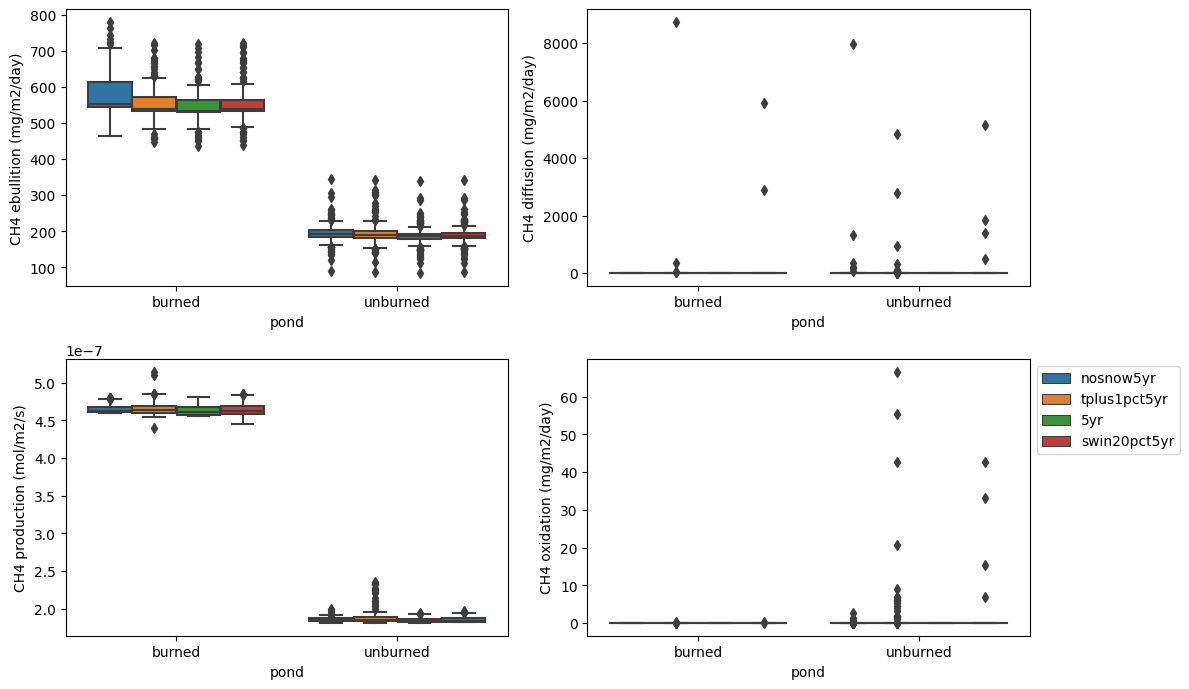

In [69]:
winter_box_data_ch4 = methane_comp_melt.loc[(methane_comp_melt['Date'].dt.month<=4) | (methane_comp_melt['Date'].dt.month>=11)]

fig, axes=plt.subplots(2,2, figsize=(12,7))
sns.boxplot(data=winter_box_data_ch4.loc[winter_box_data_ch4['variable'] == 'methane_ebul_mg/(m**2*day)'], 
            x='pond', y='value', hue='run', ax=axes[0,0])
axes[0,0].legend().remove()
#axes[0,0].legend(title='', loc='lower left')
axes[0,0].set_ylabel('CH4 ebullition (mg/m2/day)')

sns.boxplot(data=winter_box_data_ch4.loc[winter_box_data_ch4['variable'] == 'methane_turb_flux_mg/(m**2*day)'], 
            x='pond', y='value', hue='run', ax=axes[0,1])
axes[0,1].legend().remove()
axes[0,1].set_ylabel('CH4 diffusion (mg/m2/day)')
#axes[0,1].set_ylim(0,100)

sns.boxplot(data=winter_box_data_ch4.loc[winter_box_data_ch4['variable'] == 'methane_prod_young_mol/(m**2*s)'], 
            x='pond', y='value', hue='run', ax=axes[1,0])
axes[1,0].legend().remove()
axes[1,0].set_ylabel('CH4 production (mol/m2/s)')
#axes[0,2].set_ylim(0,2)

sns.boxplot(data=winter_box_data_ch4.loc[winter_box_data_ch4['variable'] == 'methane_oxid_mg/(m**2*day)'], 
            x='pond', y=winter_box_data_ch4.loc[winter_box_data_ch4['variable'] == 'methane_oxid_mg/(m**2*day)']['value']*-1, hue='run', ax=axes[1,1])
#axes[1,1].legend().remove()
axes[1,1].legend(title='', loc='upper left', bbox_to_anchor=(1, 1))
axes[1,1].set_ylabel('CH4 oxidation (mg/m2/day)')
#axes[1,1].set_ylim(0,1e-2)
#axes[1,1].set_yscale('log')

fig.tight_layout()
plt.savefig('met_exp_ch4_results_winter.jpg', dpi=300)

(19174.0, 19539.0)

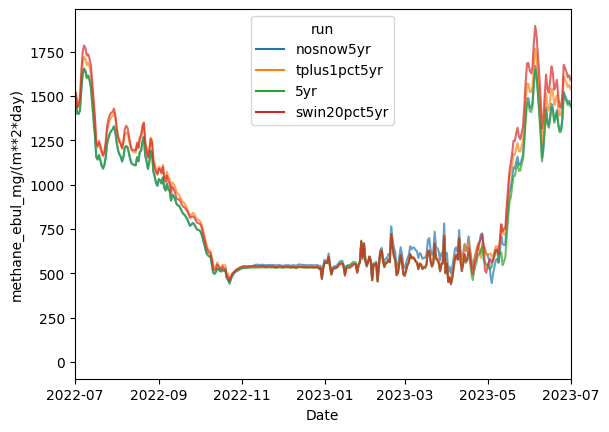

In [21]:
sns.lineplot(data= df_methanes.loc[(df_methanes['methane_ebul_mg/(m**2*day)']!=-999)& 
                                   (df_methanes['pond']=='burned')], 
                 x='Date', y='methane_ebul_mg/(m**2*day)', hue='run', alpha=0.7)
plt.xlim(pd.to_datetime('2022-07-01'),pd.to_datetime('2023-07-01'))

(19174.0, 19539.0)

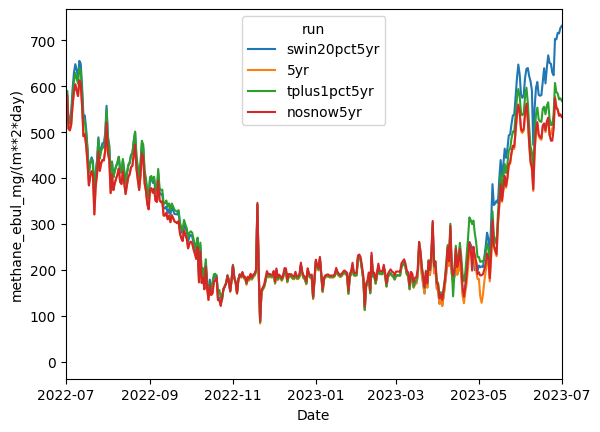

In [22]:
sns.lineplot(data= df_methanes.loc[(df_methanes['methane_ebul_mg/(m**2*day)']!=-999)& 
                                   (df_methanes['pond']=='unburned')], 
                 x='Date', y='methane_ebul_mg/(m**2*day)', hue='run')
plt.xlim(pd.to_datetime('2022-07-01'),pd.to_datetime('2023-07-01'))

(19083.0, 19539.0)

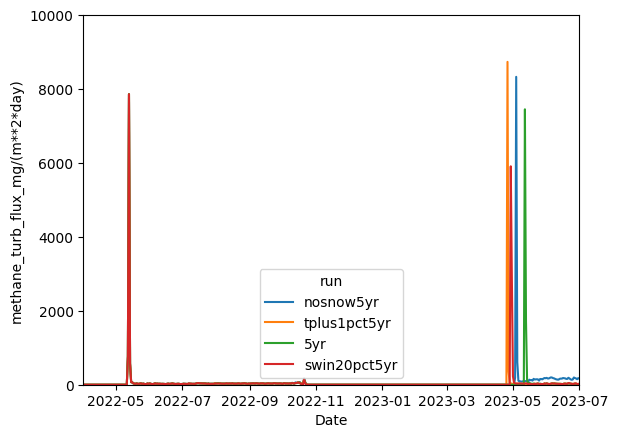

In [23]:
sns.lineplot(data= df_methanes.loc[(df_methanes['methane_turb_flux_mg/(m**2*day)']!=-999)& 
                                   (df_methanes['pond']=='burned')], 
                 x='Date', y='methane_turb_flux_mg/(m**2*day)', hue='run')
plt.ylim(0,10000)
plt.xlim(pd.to_datetime('2022-04-01'),pd.to_datetime('2023-07-01'))

(19174.0, 19539.0)

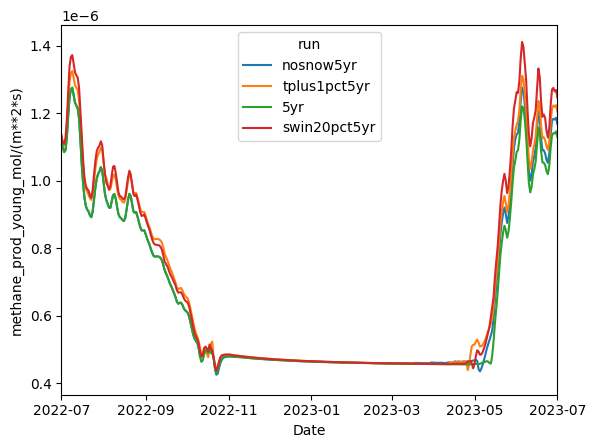

In [24]:
sns.lineplot(data= df_methanes.loc[(df_methanes['methane_prod_young_mol/(m**2*s)']!=-999)& 
                                   (df_methanes['pond']=='burned')], 
                 x='Date', y='methane_prod_young_mol/(m**2*s)', hue='run')

plt.xlim(pd.to_datetime('2022-07-01'),pd.to_datetime('2023-07-01'))

<Axes: xlabel='Date', ylabel='methane_prod_old_mol/(m**2*s)'>

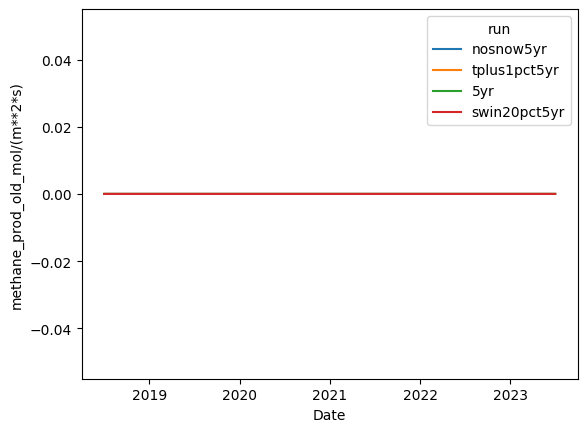

In [25]:
sns.lineplot(data= df_methanes.loc[(df_methanes['methane_prod_old_mol/(m**2*s)']!=-999)& (df_methanes['pond']=='burned')], 
                 x='Date', y='methane_prod_old_mol/(m**2*s)', hue='run')

(19174.0, 19539.0)

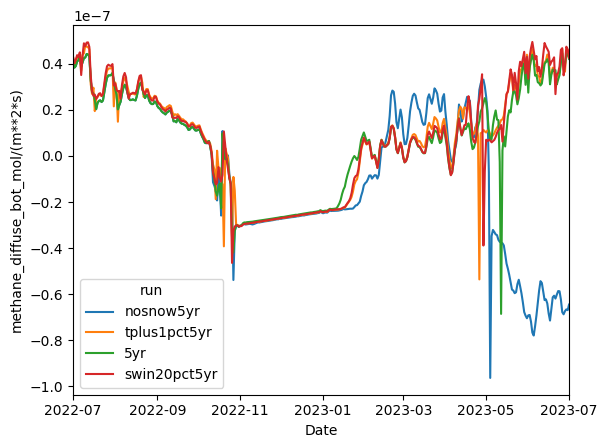

In [26]:
sns.lineplot(data= df_methanes.loc[(df_methanes['methane_diffuse_bot_mol/(m**2*s)']!=-999)& 
                                   (df_methanes['pond']=='burned')], 
                 x='Date', y='methane_diffuse_bot_mol/(m**2*s)', hue='run')
plt.xlim(pd.to_datetime('2022-07-01'),pd.to_datetime('2023-07-01'))

In [27]:
df_columns_burned = df_methanes.loc[(df_methanes['month']<=10) & (df_methanes['month']>=10)& (df_methanes['pond']=='burned')][['run', 'methane_ebul_sc1',
                                                                           'methane_ebul_sc2', 'methane_ebul_sc3', 'methane_ebul_sc4','methane_ebul_sc5']]
df_columns_burned = df_columns_burned.rename(columns = {'methane_ebul_sc1': 'column 1',
                                         'methane_ebul_sc2': 'column 2', 
                                         'methane_ebul_sc3': 'column 3', 
                                         'methane_ebul_sc4': 'column 4',
                                         'methane_ebul_sc5': 'column 5'})

df_columns_burned = df_columns_burned.groupby(by=['run']).mean().reset_index()
df_columns_burned = pd.melt(df_columns_burned, id_vars=['run'])

<Axes: xlabel='variable', ylabel='value'>

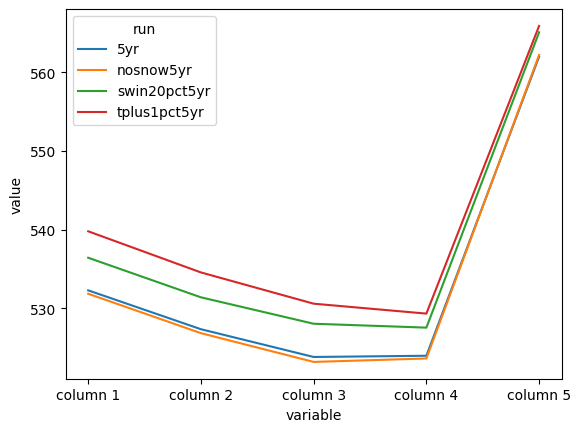

In [28]:
sns.lineplot(data=df_columns_burned, x='variable', y='value', hue='run')